# OC-DOC Relay Analysis

Pandapower supports running protection scenario analysis using Definite Time OC relay and DOC relays together in radial and meshed networks.

### Example Network

Here is a example for creating a protection scenario using the over current and directional over current relay. First, we create a meshed network with 4 buses and 5 switches. The switch is type defined as 'CB_dir' and CB_non_dir for running protection scenario analysis using over current and directional over current relay


In [2]:
def oc_doc_relay_net(open_loop=False):
    import pandapower as pp
    #create an empty network
    net = pp.create_empty_network() 
    # create buses
    bus0 = pp.create_bus(net,name = "Bus_extgrid", vn_kv = 20, type = "b")
    bus1 = pp.create_bus(net,name = "Bus_line1", vn_kv = 20, type = "b")
    bus2 = pp.create_bus(net,name = "Bus_load", vn_kv = 20, type = "b")
    bus3 = pp.create_bus(net,name = "Bus_line2", vn_kv = 20, type = "b")
    #external grids
    pp.create_ext_grid(net, bus0, vm_pu = 1.0, va_degree = 0, s_sc_max_mva = 100, s_sc_min_mva = 50, rx_max = 0.1, rx_min = 0.1)
    
    line1 = pp.create_line_from_parameters(net, bus0, bus1, length_km = 5, index = 1, r_ohm_per_km = 0.169,
                                           x_ohm_per_km = 0.118438, c_nf_per_km = 273, max_i_ka = 0.361)
    line2 = pp.create_line_from_parameters(net, bus1, bus2, length_km = 4, index = 2, r_ohm_per_km = 0.256,
                                           x_ohm_per_km = 0.126606, c_nf_per_km = 235, max_i_ka = 0.286)
    line3 = pp.create_line_from_parameters(net, bus1, bus3, length_km = 4, index = 3, r_ohm_per_km = 0.256,
                                           x_ohm_per_km = 0.126606, c_nf_per_km = 235, max_i_ka = 0.286)
    line4 = pp.create_line_from_parameters(net, bus3, bus2, length_km = 0.5, index =4, r_ohm_per_km = 0.256,
                                           x_ohm_per_km = 0.126606, c_nf_per_km = 235, max_i_ka = 0.286)
    # define short-circuit end temperature of the line\n",
    net.line["endtemp_degree"] = 250
    # create switches
    sw1 = pp.create_switch(net, bus0, line1, et="l", type = "CB_non_dir", closed = True, index = 0)
    sw2 = pp.create_switch(net, bus1, line2, et="l", type = "CB_non_dir", closed = True, index = 1)
    sw3 = pp.create_switch(net, bus1, line3, et="l", type = "CB_non_dir", closed = True, index = 2)    
    if open_loop:
        sw4 = pp.create_switch(net, bus2, line4, et="l", type = "CB_dir", closed = False, index = 3)
        sw5 = pp.create_switch(net, bus3, line4, et="l", type = "CB_dir", closed = False, index = 4)
    else:
        sw4 = pp.create_switch(net, bus2, line4, et="l", type = "CB_dir", closed = True, index = 3)
        sw5 = pp.create_switch(net, bus3, line4, et="l", type = "CB_dir", closed = True, index = 4)
    # define load
    pp.create_load(net, bus2, p_mw = 5, q_mvar= 0, scaling = 1, name="load 1") 
    # Initialise geo data
    net.bus_geodata.loc[0] = None
    net.bus_geodata.loc[1] = None
    net.bus_geodata.loc[2] = None
    net.bus_geodata.loc[3] = None
    # Define geo coordinates
    net.bus_geodata.x.at[0] = 0
    net.bus_geodata.x.at[1] = 0
    net.bus_geodata.x.at[2] =-1
    net.bus_geodata.x.at[3] =1
    net.bus_geodata.y.at[0] =1
    net.bus_geodata.y.at[1] =0
    net.bus_geodata.y.at[2] =-1
    net.bus_geodata.y.at[3] =-1
    return net

## Import OC and DOC Protection Module

Required inputs
* 1) net: (pandapowerNet) - Pandapower network with switch type as "CB_non_dir" and "CB_dir" in net.switch.type
* 2) sc_line_idx (int, index): Index of the line to create the short circuit
* 3) sc_location (float): Location of short circuit on the on line (between 0 and 1).
* 4) timegrade (list, float): Relay tripping time calculated based on topological grid search.
    - timegrade =[t_gg, t_g and t_delta]
    - t_gg: instantaneous tripping time in seconds,
    - t_g:  primary backup tripping time in seconds, 
    - t_delta: secondary backup tripping time in seconds
* 5) relay_configuration (Dict,None): For directional relay, additional informations are needed and given
    as dictionary with following inputs
           
   - relay_configuration = {'Switch_name': [switch_id,'type', 'tripping direction', RCA, OSA]}
   - switch_name (str): name of the given switch
   - switch_id (int): index of the switch
   - type (str): type of the switch (CB_dir or CB_non_dir)
   - tripping direction (str): direction of the relay (forward or reverse)
   - OSA (float, degree) : Operating Sector Angle is the quadrature angle (ideally 86° to 90°)
   - RCA (float, degree) : Relay Characteristics Angle is the angle by which the reference
     voltage is adjusted to allow better sensitivity of the directional overcurrent relay


Now, we load the network and calculate short circuit at the selected line and location using the run_fault_scenario_oc_doc_function (combinining both run_fault_scenario_oc and run_fault_scenario_doc)

In [4]:
#import oc module
from pandapower.protection.implementation import oc_relay_model as oc_protection
#import doc module
from pandapower.protection.implementation import doc_relay_model as doc_protection


In [13]:
import pandapower.shortcircuit as sc
from pandapower.protection.implementation.utility_functions import *

def run_fault_scenario_oc_doc(net, sc_line_id, sc_location,relay_configuration,tripping_time_auto=None,
                               tripping_time_manual=None,sc_fraction=0.95, overload_factor=1.2,ct_current_factor=1.25,
                               safety_factor=1,pickup_current_manual=None):
                              
    # Get trip decisions from oc relay model
    trip_decision_oc,net_sc_doc = oc_protection.run_fault_scenario_oc(net, sc_line_id=sc_line_id, sc_location=sc_location,
                            tripping_time_auto=tripping_time_auto,tripping_time_manual=tripping_time_manual,
                           sc_fraction= sc_fraction, overload_factor=overload_factor,ct_current_factor=ct_current_factor,
                           safety_factor=safety_factor,pickup_current_manual=pickup_current_manual)
    
    
    #Get trip decisions from doc relay model
    trip_decision_doc,net_sc_doc=doc_protection.run_fault_scenario_doc(net, sc_line_id=sc_line_id, sc_location=sc_location,
                            relay_configuration=relay_configuration,
                            tripping_time_auto=tripping_time_auto,tripping_time_manual=tripping_time_manual,
                           sc_fraction= sc_fraction, overload_factor=overload_factor,ct_current_factor=ct_current_factor,
                           safety_factor=safety_factor,pickup_current_manual=pickup_current_manual)
    

    # merge two trip decisions
    trip_decisions=trip_decision_oc+trip_decision_doc
    
    # create short circuit for plotting functions
    net_sc = create_sc_bus(net, sc_line_id, sc_location)
    sc.calc_sc(net_sc, bus=max(net_sc.bus.index), branch_results=True)
    
    return trip_decisions,net_sc

In [14]:
net=oc_doc_relay_net(open_loop=False)
relay_configuration = {"Switch_4": [3, "CB_dir","forward",86, 45],"Switch_5": [4,"CB_dir","forward",86,45]}

trip_decisions,net_sc= run_fault_scenario_oc_doc(net, sc_line_id=4, sc_location=0.6 ,relay_configuration=relay_configuration,
                                tripping_time_auto=[0.07,0.5,0.3],tripping_time_manual=None,
                               sc_fraction=0.95, overload_factor=1.2,ct_current_factor=1.25,
                               safety_factor=1,pickup_current_manual=None)

   Switch ID Switch type  Trip  Fault Current [kA]  Trip time [s]
0          0          OC  True            2.289141            1.1
1          1          OC  True            1.158036            0.5
2          2          OC  True            1.131105            0.8
   Switch ID Switch type  Trip  Fault Current [kA]  Trip time [s]
0          3         DOC  True            1.158036           0.07
1          4         DOC  True            1.131105           0.07


## Show tripped grid
Shows tripped switches, short circuit currents, sc location with repective annotations

use_bus_geodata is automatically set to True, since net.line_geodata is empty.


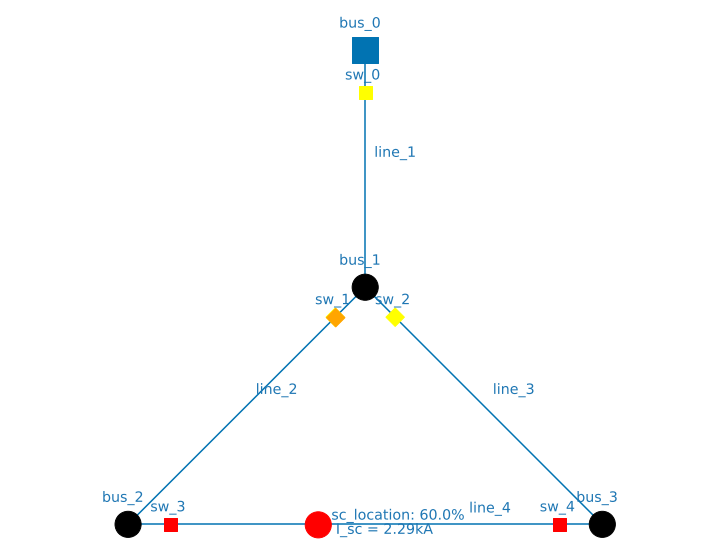

In [16]:
from pandapower.protection.implementation.utility_functions import plot_tripped_grid
plot_tripped_grid(net_sc, trip_decisions,sc_location=0.6,plot_annotations=True)

# Create I-t Plot
* Plot showing relation between current and time by using trip decisions and switch index using function create_I_t_plot from utility function


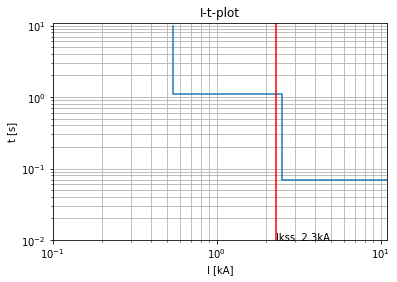

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [17]:
from pandapower.protection.implementation.utility_functions import create_I_t_plot
import matplotlib.pyplot as plt
create_I_t_plot(trip_decisions,switch_id=[0])
plt.close()

 Other functionalities are similar to the oc and doc module. Please refer to the OC and DOC tutorials 